In [ ]:
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import os
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import cv2
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras import layers, losses
import arviz as az

import pymc3 as pm
import theano.tensor as tt
import theano
from skimage.measure import compare_psnr
from PIL import Image


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

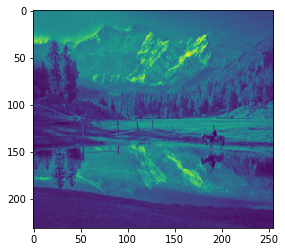

In [ ]:
data_path = 'D:/data/DIV2K Realistic Wild/Train'
data_dir_list = os.listdir(data_path)
img_data_list=[]
img_list=os.listdir(data_path+'/'+ "HR")
hr_img=cv2.imread(data_path + '/'+ "HR" + '/0002.png')
hr_img=cv2.cvtColor(hr_img, cv2.COLOR_BGR2GRAY)
ht = int(hr_img.shape[0]/4)
width = int(hr_img.shape[1]/4)
hr_img = cv2.resize(hr_img,(width, ht))

hr_img = hr_img.astype('float32')
hr_img /= 255
plt.imshow( hr_img)


lr_img=cv2.imread(data_path + '/'+ "LR" + '/0002x4w1.png')
lr_img=cv2.cvtColor(lr_img, cv2.COLOR_BGR2GRAY)
lr_ht = int(lr_img.shape[0]/2)
lr_width = int(lr_img.shape[1]/2)
lr_img = cv2.resize(lr_img,(lr_width, lr_ht))

lr_img = lr_img.astype('float32')
lr_img /= 255
plt.imshow( lr_img)

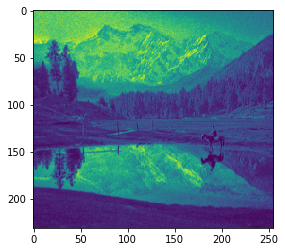

In [ ]:
data_path = 'D:/data/DIV2K Realistic Wild/Train'
data_dir_list = os.listdir(data_path)
img_data_list=[]
img_list=os.listdir(data_path+'/'+ "HR")
hr_true_img=cv2.imread(data_path + '/'+ "HR" + '/0002.png')
#hr_img=cv2.cvtColor(hr_img, cv2.COLOR_BGR2GRAY)
hb,hg,hr = cv2.split(hr_true_img)
hr_img = hb
ht = int(hr_img.shape[0]/4)
width = int(hr_img.shape[1]/4)
hr_img = cv2.resize(hr_img,(width, ht))

hr_img = hr_img.astype('float32')
hr_img /= 255
plt.imshow( hr_img)


lr_true_img=cv2.imread(data_path + '/'+ "LR" + '/0002x4w1.png')
lb, lg, lr = cv2.split(lr_true_img)
lr_img = lb
#lr_img=cv2.cvtColor(lr_img, cv2.COLOR_BGR2GRAY)
lr_ht = int(lr_img.shape[0]/2)
lr_width = int(lr_img.shape[1]/2)
lr_img = cv2.resize(lr_img,(lr_width, lr_ht))

lr_img = lr_img.astype('float32')
lr_img /= 255
plt.imshow( lr_img)

In [ ]:
lr_ht

231

In [ ]:
downsampling = tfk.Sequential([
    tfkl.InputLayer(input_shape=(ht, width, 1)),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(1, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
])

In [ ]:
downsampling.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 462, 510, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 231, 255, 1)       26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [ ]:
downsampling.load_weights('./checkpoints/downsaampling')

In [ ]:
upsaampling = tfk.Sequential([
    tfkl.InputLayer(input_shape=(lr_ht, lr_width,1)),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2DTranspose(32, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(64, 3, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(1, 3, strides=2,
                padding='same', activation=None),
])

In [ ]:
upsaampling.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 231, 255, 1)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 231, 255, 32)      832       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 231, 255, 64)      18496     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 462, 510, 1)       577       
Total params: 19,905
Trainable params: 19,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
upsaampling.load_weights('./checkpoints/upsaampling')

In [ ]:
#lr_data = lr_img.reshape(1,lr_ht,lr_width, 1)
size = ht*width

In [ ]:
decodermodel = tt._shared(upsaampling(lr_img.reshape(1,lr_ht,lr_width, 1)).numpy().flatten().astype("float64"))

In [ ]:
#decodermodel = tt._shared(trace[xs_][499])
trace = 0

In [ ]:
@theano.compile.ops.as_op(itypes=[tt.dvector],otypes=[tt.dvector])
def downsamplemodel(x):    
    dec = (downsampling(np.array(x).reshape(1,ht,width,1))).numpy().flatten().astype("float64")
    return dec


with pm.Model() as model:
    # Hidden variables
    
    #zs = pm.Normal("zs", mu=0, sigma=1, shape=(8,), dtype="float64", testval = z_int)         
    

    # Decoder and its parameters
    #dec = vae.decoder.predict(np.array([[zs[0], zs[1]]]))
    #decodermodel = decodermodel(zs)
    sig = pm.Gamma(name='sig',alpha = 3.0, beta = 1)
    # Observation model
    xs_ = pm.Normal(
        "xs_", mu=decodermodel, sigma=1, dtype="float64", shape = (size,)
    )
    
    downsamplemodel = downsamplemodel(xs_)
    ys = pm.Normal(
        "ys", mu=downsamplemodel, sigma=sig, observed=lr_img.astype("float64").flatten(), dtype="float64", 
    )

In [ ]:
with model:       
        step = pm.Metropolis()
with model:
        # draw 500 posterior samples    
        trace = pm.sample(500, step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [xs_]
>Metropolis: [sig]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [xs_]
>Metropolis: [sig]


C:\Users\Hp\anaconda3\lib\site-packages\pymc3\step_methods\metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 311 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
######Sampling finished#########

In [ ]:
np.save("sample_hb", trace[xs_][499].reshape(ht,width))

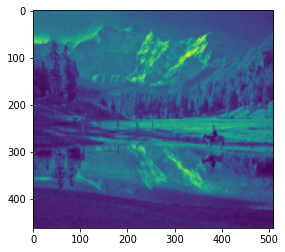

In [ ]:
plt.imshow(upsaampling(lr_img.reshape(1,lr_ht,lr_width, 1)).numpy().reshape(ht, width))

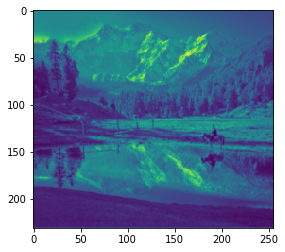

In [ ]:
plt.imshow(downsampling(hr_img.reshape(1, ht,width, 1)).numpy().reshape(lr_ht, lr_width))

In [ ]:
trace[xs_].shape

(2000, 235620)

In [ ]:
#sample_blue = trace[xs_][499].reshape(ht,width)
sample_green = trace[xs_][499].reshape(ht,width)

In [ ]:
xs_mean = np.mean(trace[xs_][:500], axis=0).reshape(ht,width)

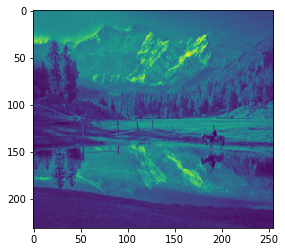

In [ ]:
plt.imshow(lr_img)

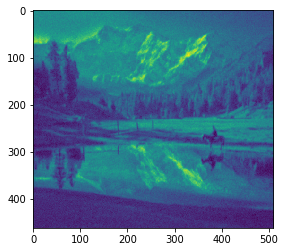

In [ ]:
plt.imshow(trace[xs_][499].reshape(ht,width))

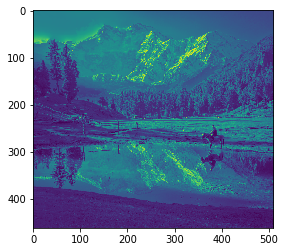

In [ ]:
plt.imshow(hr_img)

In [ ]:
plt.imshow

In [ ]:
psnr_HR = compare_psnr(hr_img, xs_mean)

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


In [ ]:
psnr_HR

22.78113879298605

In [ ]:
compare_psnr(hr_img, (upsaampling(lr_data).numpy().reshape(ht,width)))

NameError: name 'lr_data' is not defined

In [ ]:
compare_psnr(hr_img, trace[xs_][499].reshape(ht,width))

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
C:\Users\Hp\anaconda3\lib\site-packages\skimage\measure\simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)


23.54718147869199

In [ ]:
s_sample = trace[xs_][499].reshape(ht,width)*255

In [ ]:
trace = 0

In [ ]:
im = Image.fromarray(s_sample.reshape(ht,width))
if im.mode != 'RGB':
    im = im.convert('RGB')
im.save("sample.jpeg")

In [ ]:
sigma = np.mean(trace[sig][:500])

In [ ]:
lr_timg = cv2.resize(lr_true_img,(lr_width,lr_ht))
stretch_near = cv2.resize(lr_timg, (width,ht),
               interpolation = cv2.INTER_AREA)

In [ ]:
stretch_near.shape

(462, 510)

In [ ]:
nn = 23.215422308720544
bilinear = 23.487243150948522
INTER_AREA = 23.215422308720544
bicubic =  23.416949543389585
Lanczos interpolation = 23.38972471269067
above method = 22.68933763270436

In [ ]:
tru_img.shape

(462, 510, 3)

In [ ]:
compare_psnr(tru_img, stretch_near)

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


23.264588848406515

In [ ]:
hr = np.load("sample_hr.npy")
hg = np.load("sample_hg.npy")
hb = np.load("sample_hb.npy")

In [ ]:
s_img = cv2.merge((hb, hg, hr))

In [ ]:
tru_img = cv2.resize(hr_true_img,(width, ht))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


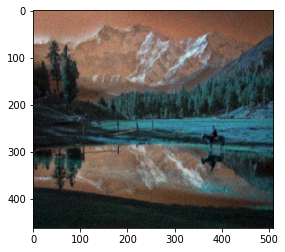

In [ ]:
plt.imshow(s_img)

In [ ]:
compare_psnr(tru_img/255, s_img)

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


22.733946413410262